In [1]:
import numpy as np
import sys
sys.path.append('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis')  # Add parent directory to path for module imports
import helper_functions
import json
import pandas as pd

In [2]:
df_e198 = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08020/Network/000035/well002/metrics_curated.xlsx")

df_e200 = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M05506/Network/000038/well004/metrics_curated.xlsx")

df_healthy = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08018/Network/000032/well005/metrics_curated.xlsx")

In [3]:
df_healthy['NeuronType'] = 'Healthy'
df_e198['NeuronType'] = "E198"
df_e200["NeuronType"] = "E200"

In [4]:
df_all = pd.concat([df_healthy,df_e198,df_e200],axis=0,ignore_index=True)

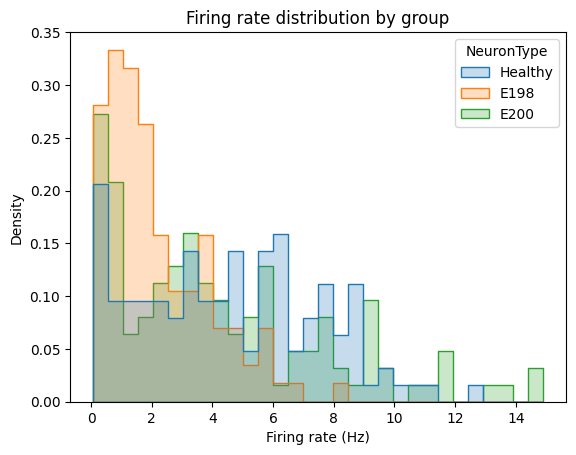

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.histplot(
    data=df_all,
    x='firing_rate',
    hue='NeuronType',
    bins=30,
    element='step',
    stat='density',
    common_norm=False
)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Density')
plt.title('Firing rate distribution by group')
plt.show()

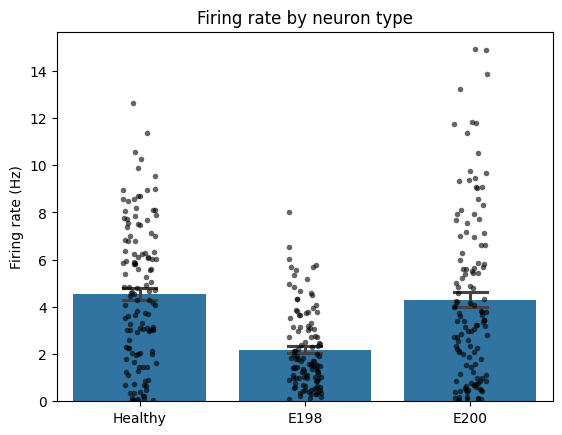

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()

# Bar plot (mean ± SE)
sns.barplot(
    data=df_all,
    x='NeuronType',
    y='firing_rate',
    errorbar='se',   # <-- FIX
    capsize=0.2,
)

# Scatter points (individual units)
sns.stripplot(
    data=df_all,
    x='NeuronType',
    y='firing_rate',
    color='black',
    alpha=0.6,
    jitter=True,
    size=4
)

plt.ylabel('Firing rate (Hz)')
plt.xlabel('')
plt.title('Firing rate by neuron type')
plt.show()

In [7]:
df_all.columns

Index(['Unnamed: 0', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
       'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
       'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
       'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
       'sd_ratio', 'noise_cutoff', 'noise_ratio', 'loc_x', 'loc_y',
       'NeuronType'],
      dtype='object')

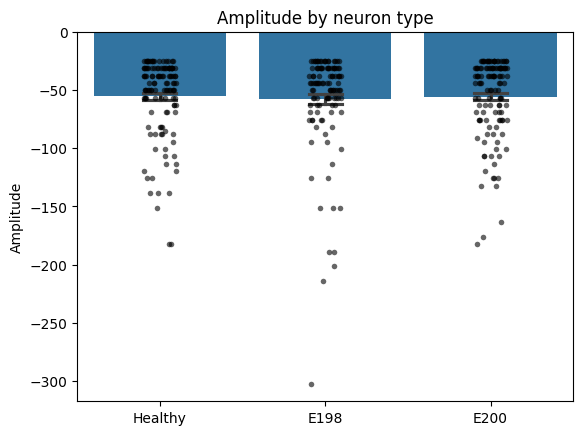

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()

# Bar plot (mean ± SE)
sns.barplot(
    data=df_all,
    x='NeuronType',
    y='amplitude_median',
    errorbar='se',   # <-- FIX
    capsize=0.2,
)

# Scatter points (individual units)
sns.stripplot(
    data=df_all,
    x='NeuronType',
    y='amplitude_median',
    color='black',
    alpha=0.6,
    jitter=True,
    size=4
)

plt.ylabel('Amplitude')
plt.xlabel('')
plt.title('Amplitude by neuron type')
plt.show()

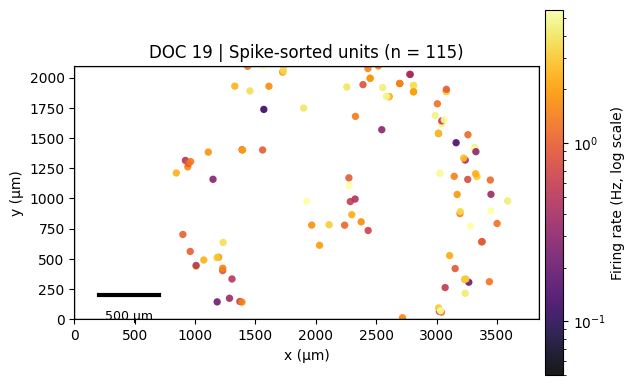

In [9]:
# Spatial map of spike-sorted units on Maxwell HD-MEA
# Publication-ready version (DOC 19–style panel)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

# -----------------------------
# Parameters (DO NOT HIDE THESE)
# -----------------------------
ACTIVE_W = 3850   # µm (x-dimension)
ACTIVE_H = 2100   # µm (y-dimension)
SCALE_BAR = 500   # µm
FR_MIN = 0.05     # Hz (lower bound for log scale)
FR_PCTL = 95      # clip extreme firing rates

# -----------------------------
# Data prep
# -----------------------------
fr = df_e198['firing_rate'].values
x = df_e198['loc_x'].values
y = df_e198['loc_y'].values

vmax = np.percentile(fr, FR_PCTL)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(6.5, 4))

sc = ax.scatter(
    x, y,
    c=fr,
    cmap='inferno',
    norm=LogNorm(vmin=FR_MIN, vmax=vmax),
    s=28,
    linewidth=0,
    alpha=0.9
)

# Active-area outline (Maxwell HD-MEA)
ax.add_patch(
    Rectangle(
        (0, 0),
        ACTIVE_W,
        ACTIVE_H,
        fill=False,
        edgecolor='black',
        linewidth=1
    )
)

# Axes + limits
ax.set_xlim(0, ACTIVE_W)
ax.set_ylim(0, ACTIVE_H)
ax.set_aspect('equal')
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')

# Scale bar
x0, y0 = 200, 200
ax.plot([x0, x0 + SCALE_BAR], [y0, y0], 'k-', lw=3)
ax.text(
    x0 + SCALE_BAR / 2,
    y0 - 120,
    f'{SCALE_BAR} µm',
    ha='center',
    va='top',
    fontsize=9
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.01)
cbar.set_label('Firing rate (Hz, log scale)')

# Title (adjust genotype text as needed)
ax.set_title(f'DOC 19 | Spike-sorted units (n = {len(fr)})')

plt.tight_layout()
plt.show()

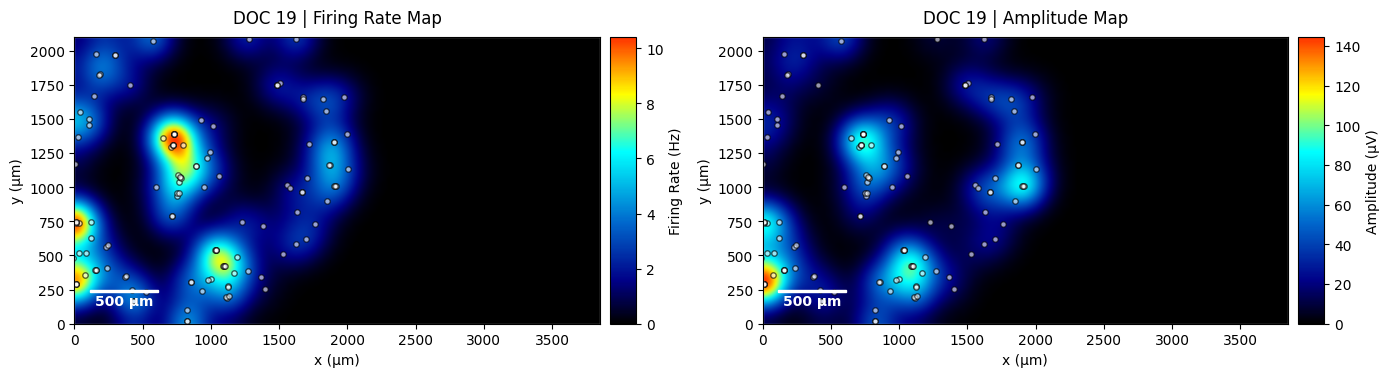

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable


df_here =df_healthy.copy()
file_path = '/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08018/Network/000032/well005//spikesorted_unit_maps.svg'
# -----------------------------
# 1. Setup Parameters
# -----------------------------
ACTIVE_W = 3850   
ACTIVE_H = 2100   
SCALE_BAR = 500   
SIGMA_UM = 120    
BIN_SIZE = 20     

# -----------------------------
# 2. Load Data (Assumes df_e198 exists)
# -----------------------------
# Ensure df_e198 is loaded!
x = df_here['loc_x'].values
y = df_here['loc_y'].values
fr = df_here['firing_rate'].values

# Handle Amplitude (Absolute Value)
if 'amplitude_median' in df_here.columns:
    # Use 98th percentile as the "Max" to avoid one crazy outlier skewing the scale
    amp = np.abs(df_here['amplitude_median'].values)
    amp_max_target = np.percentile(amp, 98) 
else:
    amp = fr
    amp_max_target = np.percentile(fr, 98)

fr_max_target = np.percentile(fr, 98) # Target max for Firing Rate

# -----------------------------
# 3. Helper Functions
# -----------------------------
def get_maxwell_cmap():
    colors = [(0.0, 'black'), (0.15, '#000088'), (0.35, '#0066cc'),
              (0.6, '#00ffff'), (0.8, '#ffff00'), (1.0, '#ff3300')]
    return LinearSegmentedColormap.from_list('maxwell_amp', colors)

def make_heatmap(x_vals, y_vals, weights, width, height, sigma_um, bin_size, max_target):
    """
    Generates a map and re-normalizes it so the peak intensity matches 'max_target'.
    """
    # 1. Create Grid
    x_bins = np.arange(0, width + bin_size, bin_size)
    y_bins = np.arange(0, height + bin_size, bin_size)
    
    # 2. Weighted Histogram (The sparse map)
    heatmap, _, _ = np.histogram2d(x_vals, y_vals, bins=[x_bins, y_bins], weights=weights)
    
    # 3. Gaussian Smoothing (This lowers the values)
    sigma_pixel = sigma_um / bin_size
    heatmap_smooth = gaussian_filter(heatmap.T, sigma=sigma_pixel)
    
    # 4. RE-NORMALIZATION (The Fix)
    # Scale the map so the highest peak matches the real data's top 2%
    current_max = np.max(heatmap_smooth)
    if current_max > 0:
        heatmap_norm = heatmap_smooth * (max_target / current_max)
    else:
        heatmap_norm = heatmap_smooth
        
    return heatmap_norm

# -----------------------------
# 4. Plotting
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
maxwell_cmap = get_maxwell_cmap()

configs = [
    {
        'ax': axes[0], 
        'data': fr,  
        'target': fr_max_target, # Pass the real data max (e.g. 8.0 Hz)
        'title': 'Firing Rate Map', 
        'cbar': 'Firing Rate (Hz)'
    },
    {
        'ax': axes[1], 
        'data': amp, 
        'target': amp_max_target, # Pass the real data max (e.g. 300 uV)
        'title': 'Amplitude Map',       
        'cbar': 'Amplitude (µV)'
    }
]

for conf in configs:
    ax = conf['ax']
    data_weights = conf['data']
    
    # Generate Map with Normalization
    # We pass the real data maximum (target) into the function
    heatmap_final = make_heatmap(x, y, data_weights, ACTIVE_W, ACTIVE_H, SIGMA_UM, BIN_SIZE, conf['target'])
    
    # Plot Image
    img = ax.imshow(
        heatmap_final, 
        extent=[0, ACTIVE_W, 0, ACTIVE_H], 
        origin='lower', 
        cmap=maxwell_cmap, 
        vmin=0, 
        vmax=conf['target'], # Set scale to match the data target
        interpolation='bicubic'
    )
    
    # Overlay Dots
    ax.scatter(x, y, s=15, facecolors='white', edgecolors='black', alpha=0.6)

    # Scale Bar
    scalebar = AnchoredSizeBar(ax.transData, SCALE_BAR, f'{SCALE_BAR} µm', 'lower left', 
                               pad=1, color='white', frameon=False, size_vertical=ACTIVE_H * 0.005,
                               fontproperties={'weight': 'bold', 'size': 10})
    ax.add_artist(scalebar)
    
    # Formatting
    ax.set_facecolor('black')
    ax.set_title(f"DOC 19 | {conf['title']}", fontsize=12, pad=10)
    ax.set_xlabel('x (µm)')
    ax.set_ylabel('y (µm)')
    ax.set_xlim(0, ACTIVE_W)
    ax.set_ylim(0, ACTIVE_H)
    ax.add_patch(Rectangle((0, 0), ACTIVE_W, ACTIVE_H, fill=False, edgecolor='white', lw=1, alpha=0.5))
    
    # Perfect Fit Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label(conf['cbar'])

plt.tight_layout()
plt.savefig(file_path, dpi=300,format='svg')
plt.show()

In [13]:
df_e198[['firing_rate', 'amplitude_median']].describe()

,firing_rate,amplitude_median
count,115.000000,115.000000
mean,2.192551,-58.071302
std,1.671577,44.577765
min,0.116667,-302.124023
25%,0.970000,-62.942505
50%,1.693333,-44.059753
75%,3.156667,-31.471252
max,8.016667,-25.177002


In [16]:
template_df_e198 = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08020/Network/000035/well002/tm_curated.xlsx")

In [17]:
template_df_e198.columns

Index(['Unnamed: 0', 'peak_to_valley', 'peak_trough_ratio', 'half_width',
       'repolarization_slope', 'recovery_slope', 'num_positive_peaks',
       'num_negative_peaks'],
      dtype='object')

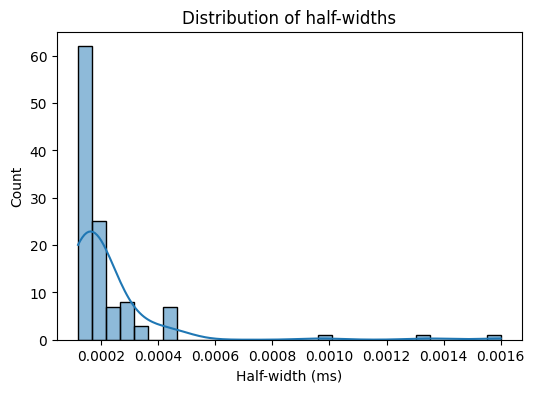

In [19]:
#print half width distribution
half_widths = template_df_e198['half_width'].values
plt.figure(figsize=(6,4))
sns.histplot(half_widths, bins=30, kde=True)
plt.xlabel('Half-width (ms)')
plt.title('Distribution of half-widths')
plt.show()


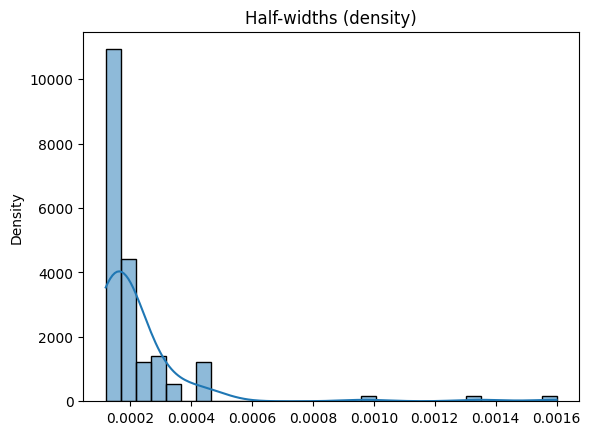

In [20]:
# Option 1: Histogram + KDE (linear y)
sns.histplot(half_widths, bins=30, kde=True, stat='density')
plt.title('Half-widths (density)')
plt.show()

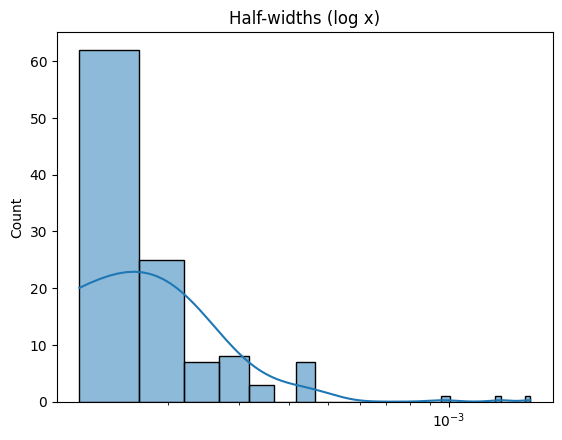

In [21]:
# Option 2: Log x-axis if distribution is skewed
sns.histplot(half_widths, bins=30, kde=True)
plt.xscale('log')
plt.title('Half-widths (log x)')
plt.show()

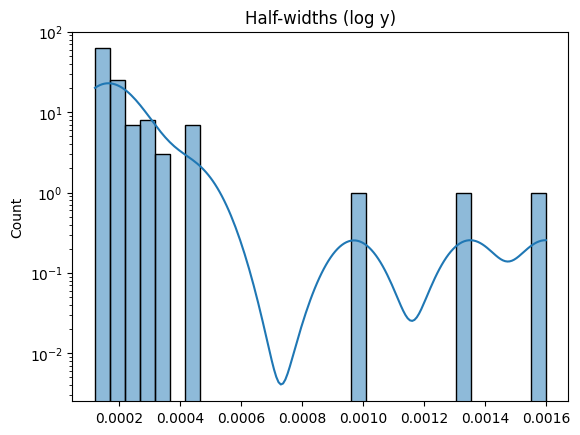

In [22]:
# Option 3: Log y-axis (only if you want to see tail structure)
sns.histplot(half_widths, bins=30, kde=True)
plt.yscale('log')
plt.title('Half-widths (log y)')
plt.show()

Merged on index (n=115)
Pearson r = 0.021
Spearman r = -0.035


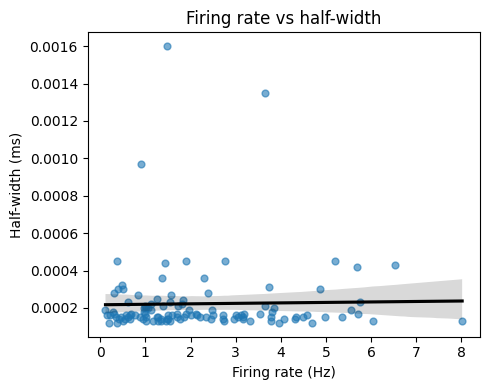

In [24]:
# Correlation between firing rate and half-width
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# firing_rate in df_e198, half_width in template_df_e198
keys_priority = ['unit_id', 'unitID', 'UnitID', 'cluster_id', 'ClusterID', 'unit']
common_keys = [k for k in keys_priority if k in df_e198.columns and k in template_df_e198.columns]

if common_keys:
    key = common_keys[0]
    merged = pd.merge(
        df_e198[[key, 'firing_rate']],
        template_df_e198[[key, 'half_width']],
        on=key,
        how='inner'
    )
    print(f"Merged on {key} (n={len(merged)})")
else:
    # Fall back to index alignment if no explicit key exists
    merged = df_e198[['firing_rate']].join(
        template_df_e198[['half_width']],
        how='inner'
    )
    print(f"Merged on index (n={len(merged)})")

df_corr = merged[['firing_rate', 'half_width']].dropna()
if len(df_corr) > 1:
    pearson_r = df_corr['firing_rate'].corr(df_corr['half_width'], method='pearson')
    spearman_r = df_corr['firing_rate'].corr(df_corr['half_width'], method='spearman')
    print(f"Pearson r = {pearson_r:.3f}")
    print(f"Spearman r = {spearman_r:.3f}")

    plt.figure(figsize=(5,4))
    sns.regplot(
        data=df_corr,
        x='firing_rate',
        y='half_width',
        scatter_kws={'alpha': 0.6, 's': 24},
        line_kws={'color': 'black'}
    )
    plt.title('Firing rate vs half-width')
    plt.xlabel('Firing rate (Hz)')
    plt.ylabel('Half-width (ms)')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough matched units to compute correlation.")

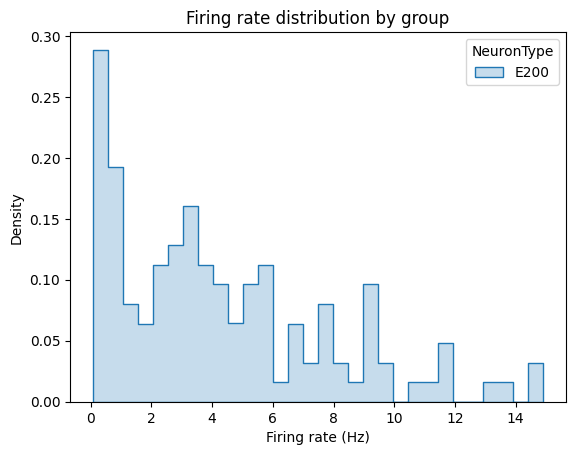

In [26]:
#firing rate distribution

sns.histplot(
    data=df_e200,
    x='firing_rate',
    hue='NeuronType',
    bins=30,
    element='step',
    stat='density',
    common_norm=False
)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Density')
plt.title('Firing rate distribution by group')
plt.show()

In [1]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08018/Network/000032/"
output_filename = "merged_metrics_healthy.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_healthy = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_healthy["NeuronType"] = "Healthy"  # Add NeuronType column with "Healthy" value
    merged_df_healthy.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_healthy)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_healthy.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08018/Network/000032/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (82 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (116 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (140 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (61 rows)
[SUCCESS] Loaded: well004/metrics_curated.xlsx (0 rows)
[SUCCESS] Loaded: well005/metrics_curated.xlsx (127 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 526
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08018/Network/000032/merged_metrics_healthy.xlsx

Preview of merged data:
  Source_Well Unnamed: 0 num_spikes  firing_rate  presence_ratio        snr  \
0     well000          1        268     0.893333             1.0   4.472270   
1     well000          2        211     0.7

/tmp/ipykernel_1377691/1027160679.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df_healthy = pd.concat(dfs, ignore_index=True)


In [2]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08020/Network/000035/"
output_filename = "merged_metrics_e198.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_e198 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_e198["NeuronType"] = "E198K"  # Add NeuronType column with "E198" value
    merged_df_e198.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_e198)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_e198.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08020/Network/000035/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (198 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (113 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (115 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (121 rows)
[SUCCESS] Loaded: well004/metrics_curated.xlsx (76 rows)
[SUCCESS] Loaded: well005/metrics_curated.xlsx (70 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 693
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M08020/Network/000035/merged_metrics_e198.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  num_spikes  firing_rate  presence_ratio       snr  \
0     well000           2         353     1.176667             1.0  5.487634   
1     well000           3         663     

In [3]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M05506/Network/000038/"
output_filename = "merged_metrics_e200.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_e200 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_e200["NeuronType"] = "E200K"  # Add NeuronType column with "E200" value
    merged_df_e200.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_e200)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_e200.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M05506/Network/000038/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (60 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (172 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (125 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (139 rows)
[SUCCESS] Loaded: well004/metrics_curated.xlsx (126 rows)
[SUCCESS] Loaded: well005/metrics_curated.xlsx (192 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 814
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250127/M05506/Network/000038/merged_metrics_e200.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  num_spikes  firing_rate  presence_ratio       snr  \
0     well000           5        4744    15.813333             1.0  4.598675   
1     well000           6         839    

In [4]:
#now merge all three dataframes together
df_all = pd.concat([merged_df_healthy, merged_df_e198, merged_df_e200], axis=0, ignore_index=True)
print(f"Combined DataFrame shape: {df_all.shape}")
print(df_all['NeuronType'].value_counts())

Combined DataFrame shape: (2033, 25)
NeuronType
E200K      814
E198K      693
Healthy    526
Name: count, dtype: int64


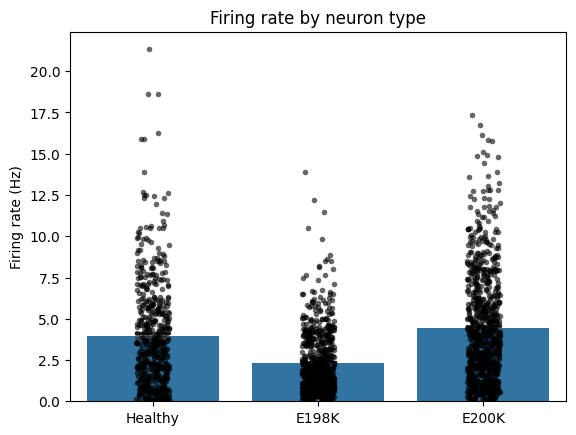

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()

# Bar plot (mean ± SE)
sns.barplot(
    data=df_all,
    x='NeuronType',
    y='firing_rate',
    errorbar='se',   # <-- FIX
    capsize=0.2,
)

# Scatter points (individual units)
sns.stripplot(
    data=df_all,
    x='NeuronType',
    y='firing_rate',
    color='black',
    alpha=0.6,
    jitter=True,
    size=4
)

plt.ylabel('Firing rate (Hz)')
plt.xlabel('')
plt.title('Firing rate by neuron type')
plt.show()

Stats Results (Welch's t-test):
  Healthy vs E198K: p = 0.0403
  Healthy vs E200K: p = 0.4294


/tmp/ipykernel_1377691/4249203525.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_1377691/4249203525.py:61: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


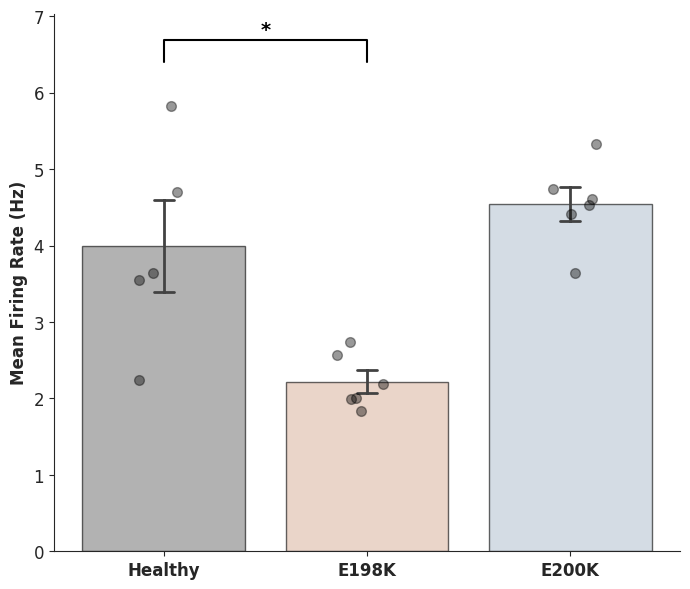

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# ---------------------------------------------------------
# 1. SETUP: Define Order and Filter Data
# ---------------------------------------------------------
order_list = ['Healthy', 'E198K', 'E200K']
df_clean = df_all[df_all['firing_rate'] >= 0.1].copy()

# ---------------------------------------------------------
# 2. AGGREGATE: Calculate Well Means
# ---------------------------------------------------------
df_well_means = df_clean.groupby(['NeuronType', 'Source_Well'])['firing_rate'].mean().reset_index()

# ---------------------------------------------------------
# 3. STATS: Welch's T-Test
# ---------------------------------------------------------
# Extract the firing rates for each group
healthy = df_well_means[df_well_means['NeuronType'] == 'Healthy']['firing_rate']
e198k = df_well_means[df_well_means['NeuronType'] == 'E198K']['firing_rate']
e200k = df_well_means[df_well_means['NeuronType'] == 'E200K']['firing_rate']

# Perform pairwise t-tests (Welch's: equal_var=False)
t_198, p_198 = stats.ttest_ind(healthy, e198k, equal_var=False)
t_200, p_200 = stats.ttest_ind(healthy, e200k, equal_var=False)

print(f"Stats Results (Welch's t-test):")
print(f"  Healthy vs E198K: p = {p_198:.4f}")
print(f"  Healthy vs E200K: p = {p_200:.4f}")

# Helper function to convert p-value to stars
def get_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'ns'

# ---------------------------------------------------------
# 4. PLOTTING
# ---------------------------------------------------------
plt.figure(figsize=(7, 6))
sns.set_style("ticks") # Clean white background style

# A. Bar Plot (Mean + SE)
ax = sns.barplot(
    data=df_well_means,
    x='NeuronType',
    y='firing_rate',
    order=order_list,     # <--- ENFORCED ORDER
    errorbar='se',
    capsize=0.1,
    alpha=0.6,
    palette=['gray', '#E6B89C', '#B4C5D6'], # Custom colors matching your reference image
    edgecolor='black',
    err_kws={'linewidth': 2}
)

# B. Strip Plot (Individual Wells)
sns.stripplot(
    data=df_well_means,
    x='NeuronType',
    y='firing_rate',
    order=order_list,     # <--- ENFORCED ORDER
    color='black',
    size=7,
    jitter=0.15,
    alpha=0.4,            # Transparent dots
    edgecolor='gray',     # Slight border on dots
    linewidth=1
)

# ---------------------------------------------------------
# 5. DRAW SIGNIFICANCE BARS
# ---------------------------------------------------------
# Get the max height to position bars above the data
y_max = df_well_means['firing_rate'].max()
h = y_max * 0.05  # Height of the bracket legs

# Function to draw bracket
def draw_bracket(idx1, idx2, p_val, y_pos):
    stars = get_stars(p_val)
    if stars == 'ns': return # Skip if not significant (optional)
    
    x1, x2 = idx1, idx2
    line_y = y_pos + h
    
    # Draw the bracket lines
    plt.plot([x1, x1, x2, x2], [y_pos, line_y, line_y, y_pos], lw=1.5, c='k')
    
    # Add the text (stars)
    plt.text((x1+x2)/2, line_y, stars, ha='center', va='bottom', color='k', fontsize=14, fontweight='bold')

# Draw brackets (0=Healthy, 1=E198K, 2=E200K)
# Adjust 'y_max + ...' multipliers to stack brackets nicely
draw_bracket(0, 1, p_198, y_max + (y_max * 0.1))
draw_bracket(0, 2, p_200, y_max + (y_max * 0.25))

# ---------------------------------------------------------
# 6. FORMATTING
# ---------------------------------------------------------
plt.ylabel('Mean Firing Rate (Hz)', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
sns.despine() # Removes top and right borders
plt.tight_layout()
plt.savefig("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/firing_rate_DIV19.svg", dpi=300, format='svg')
plt.show()

Stats Results (Welch's t-test):
  Healthy vs E198K: p = 0.9822
  Healthy vs E200K: p = 0.6008


/tmp/ipykernel_1377691/774398191.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_1377691/774398191.py:63: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


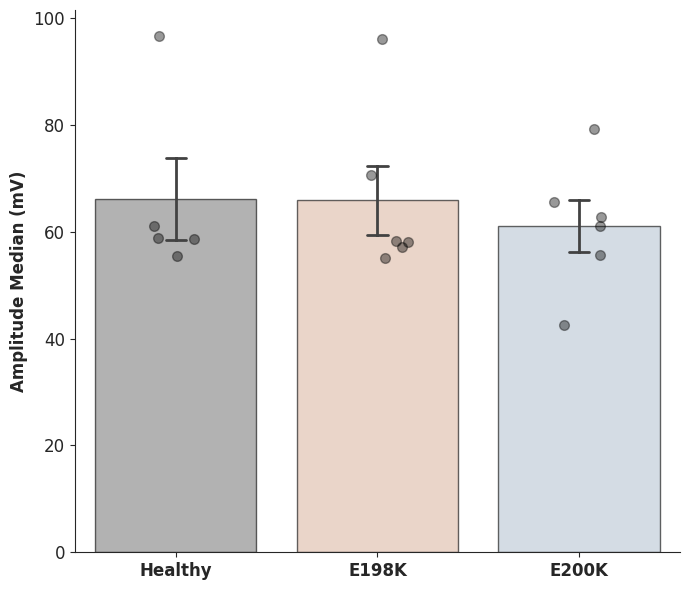

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# ---------------------------------------------------------
# 1. SETUP: Define Order and Filter Data
# ---------------------------------------------------------
order_list = ['Healthy', 'E198K', 'E200K']

df_all['amplitude_median_abs'] = np.abs(df_all['amplitude_median'])
df_clean = df_all[df_all['amplitude_median_abs'] >= 20].copy()
# ---------------------------------------------------------
# 2. AGGREGATE: Calculate Well Means
# ---------------------------------------------------------
df_well_means = df_clean.groupby(['NeuronType', 'Source_Well'])['amplitude_median_abs'].mean().reset_index()

# ---------------------------------------------------------
# 3. STATS: Welch's T-Test
# ---------------------------------------------------------
# Extract the firing rates for each group
#get abs values of amplitude median for each group
healthy = df_well_means[df_well_means['NeuronType'] == 'Healthy']['amplitude_median_abs']
e198k = df_well_means[df_well_means['NeuronType'] == 'E198K']['amplitude_median_abs']
e200k = df_well_means[df_well_means['NeuronType'] == 'E200K']['amplitude_median_abs']

# Perform pairwise t-tests (Welch's: equal_var=False)
t_198, p_198 = stats.ttest_ind(healthy, e198k, equal_var=False)
t_200, p_200 = stats.ttest_ind(healthy, e200k, equal_var=False)

print(f"Stats Results (Welch's t-test):")
print(f"  Healthy vs E198K: p = {p_198:.4f}")
print(f"  Healthy vs E200K: p = {p_200:.4f}")

# Helper function to convert p-value to stars
def get_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'ns'

# ---------------------------------------------------------
# 4. PLOTTING
# ---------------------------------------------------------
plt.figure(figsize=(7, 6))
sns.set_style("ticks") # Clean white background style

# A. Bar Plot (Mean + SE)
ax = sns.barplot(
    data=df_well_means,
    x='NeuronType',
    y='amplitude_median_abs',
    order=order_list,     # <--- ENFORCED ORDER
    errorbar='se',
    capsize=0.1,
    alpha=0.6,
    palette=['gray', '#E6B89C', '#B4C5D6'], # Custom colors matching your reference image
    edgecolor='black',
    err_kws={'linewidth': 2}
)

# B. Strip Plot (Individual Wells)
sns.stripplot(
    data=df_well_means,
    x='NeuronType',
    y='amplitude_median_abs',
    order=order_list,     # <--- ENFORCED ORDER
    color='black',
    size=7,
    jitter=0.15,
    alpha=0.4,            # Transparent dots
    edgecolor='gray',     # Slight border on dots
    linewidth=1
)

# ---------------------------------------------------------
# 5. DRAW SIGNIFICANCE BARS
# ---------------------------------------------------------
# Get the max height to position bars above the data
y_max = df_well_means['amplitude_median_abs'].max()
h = y_max * 0.05  # Height of the bracket legs

# Function to draw bracket
def draw_bracket(idx1, idx2, p_val, y_pos):
    stars = get_stars(p_val)
    if stars == 'ns': return # Skip if not significant (optional)
    
    x1, x2 = idx1, idx2
    line_y = y_pos + h
    
    # Draw the bracket lines
    plt.plot([x1, x1, x2, x2], [y_pos, line_y, line_y, y_pos], lw=1.5, c='k')
    
    # Add the text (stars)
    plt.text((x1+x2)/2, line_y, stars, ha='center', va='bottom', color='k', fontsize=14, fontweight='bold')

# Draw brackets (0=Healthy, 1=E198K, 2=E200K)
# Adjust 'y_max + ...' multipliers to stack brackets nicely
draw_bracket(0, 1, p_198, y_max + (y_max * 0.1))
draw_bracket(0, 2, p_200, y_max + (y_max * 0.25))

# ---------------------------------------------------------
# 6. FORMATTING
# ---------------------------------------------------------
plt.ylabel('Amplitude Median (mV)', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
sns.despine() # Removes top and right borders
plt.tight_layout()
plt.savefig("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/amplitude_median_DIV19.svg", dpi=300, format='svg')
plt.show()